In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.preprocessing import  PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
df = pd.read_csv("dublinbikes_20200101_20200401.csv",parse_dates=True)

In [2]:
cityCentre=df[df['STATION ID'].isin([80])]
print("shape of cityCentre:",cityCentre.shape)
cityCentre=cityCentre.to_numpy()
cityCentre=cityCentre[1802:15626,:]
city_Month=[];city_Day=[];city_Hour=[];city_Min=[];c=0
for i in range(0,len(cityCentre)):
    cityCentre[i][2]=datetime.datetime.strptime(cityCentre[i][2], "%Y-%m-%d %H:%M:%S")
    city_Month.append(cityCentre[i][2].month)
    city_Day.append(cityCentre[i][2].day)
    city_Hour.append(cityCentre[i][2].hour)
    city_Min.append(cityCentre[i][2].minute)

city_Month=np.array(city_Month).reshape(-1,1);city_Day=np.array(city_Day).reshape(-1,1)
city_Hour=np.array(city_Hour).reshape(-1,1);city_Min=np.array(city_Min).reshape(-1,1)
record_data=np.concatenate((city_Month,city_Day,city_Hour,city_Min),axis=1)
cityCentreAvaliable=cityCentre[:,6].reshape(-1,1)

cityCentre=cityCentreAvaliable

shape of cityCentre: (20369, 11)


In [11]:
start=4032
def series_to_supervised_time(data, time_size,start,skip):
    size=len(data)-start
    para_size=data.shape[1]
    sampletimes=np.empty([size,time_size*para_size])
    target=np.empty([size,time_size*para_size])
    target=cityCentreAvaliable[start:,:]
    for i in range(size):
        for j in range(time_size):
            #sampletimes[i,j*para_size:(j+1)*para_size]=cityCentre[start+i-12-j*skip,:]#predict 1h
            #sampletimes[i,j*para_size:(j+1)*para_size]=cityCentre[start+i-6-j*skip,:]#predict 30mins
            sampletimes[i,j*para_size:(j+1)*para_size]=cityCentre[start+i-2-j*skip,:]#predict 10mins
    return sampletimes,target  

def series_to_supervised_day(data, time_size, start):
    size=len(data)-start
    para_size=data.shape[1]
    sampledays=np.empty([size,time_size*para_size])
    for i in range(size):
        for j in range(time_size):
            sampledays[i,j*para_size:(j+1)*para_size]=cityCentre[start+i-288*(j+1),:]
    return sampledays
def series_to_supervised_week(data, time_size, start):
    size=len(data)-start
    para_size=data.shape[1]
    sampleweeks=np.empty([size,time_size*para_size])
    for i in range(size):
        for j in range(time_size):
            sampleweeks[i,j*para_size:(j+1)*para_size]=cityCentre[start+i-288*7*(j+1),:]
    return sampleweeks

sampletimes,target=series_to_supervised_time(cityCentre, 10, start,1)
sampledays=series_to_supervised_day(cityCentre,0,start)
sampleweeks=series_to_supervised_day(cityCentre,0,start)
sample=np.concatenate((sampletimes,sampledays,sampleweeks),axis=1)
baseline=sampletimes
scale=MinMaxScaler()
scale.fit(sample)
sample=scale.transform(sample)
print(target.shape)
print(sampletimes.shape)
print(sampledays.shape)
print(sampleweeks.shape)

(9792, 1)
(9792, 10)
(9792, 0)
(9792, 0)


In [12]:
sampleTest=sample[7000:,:];targetTest=target[7000:,:];targetTest=targetTest.reshape(2792,)
sample=sample[:7000];target=target[:7000].reshape(len(target[:7000]),)

mean_error: [13.055535714285716, 12.144153362508938, 11.881033755763227, 12.249680284611195, 12.568338686603733, 12.964411795272516]
absolute_error: [1.9030357142857144, 1.8701219486159069, 1.8450974774005078, 1.8569036456539192, 1.8729213252644563, 1.9014722553220462]
score: 0.9775922340863762


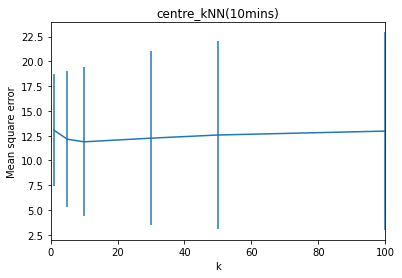

In [13]:
mean_error=[];std_error=[];absolute_error=[]
temp=[]
absolute=[]
tscv = TimeSeriesSplit(n_splits=4)
k_range=[1,5,10,30,50,100]
for k in k_range:
    model = KNN(n_neighbors=k,weights='distance')
    for train, test in tscv.split(sample):
        model.fit(sample[train],target[train])
        pred=model.predict(sample[test])
        temp.append(mean_squared_error(target[test],pred))
        absolute.append(mean_absolute_error(target[test],pred))
    mean_error.append(np.array(temp).mean())
    absolute_error.append(np.array(absolute).mean())
    std_error.append(np.array(temp).std())
print('mean_error:',mean_error)
print('absolute_error:',absolute_error)
score = model.score(sample,target)
print('score:',score)
plt.errorbar(k_range,mean_error,yerr=std_error)
plt.title('centre_kNN(10mins)')
plt.xlabel('k'); plt.ylabel('Mean square error')
plt.xlim((0,100))
plt.show()

mean_error: [4.347658660130718, 4.476074046840958, 4.630833387799565, 4.770127437363835, 4.9123833660130725]
absolute_error: [1.0132162309368191, 1.0070765250544662, 1.0212463689179374, 1.0393824891067538, 1.0579602396514158]
score: 0.9550135717946641


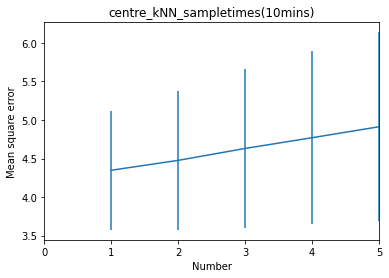

In [14]:
mean_error=[];std_error=[];absolute_error=[]
temp=[]
absolute=[]
tscv = TimeSeriesSplit(n_splits=3)
c_range=[1,2,3,4,5]
for c in c_range:
    model = KNN(n_neighbors=50,weights='uniform')
    sampletimes,target=series_to_supervised_time(cityCentre, c, start,1)
    sample=sampletimes
    scale=MinMaxScaler()
    scale.fit(sample)
    sample=scale.transform(sample)
    for train, test in tscv.split(sample):
        model.fit(sample[train],target[train])
        pred=model.predict(sample[test])
        temp.append(mean_squared_error(target[test],pred))
        absolute.append(mean_absolute_error(target[test],pred))
    mean_error.append(np.array(temp).mean())
    absolute_error.append(np.array(absolute).mean())
    std_error.append(np.array(temp).std())
print('mean_error:',mean_error)
print('absolute_error:',absolute_error)
score = model.score(sample,target)
print('score:',score)
plt.errorbar(c_range,mean_error,yerr=std_error)
plt.title('centre_kNN_sampletimes(10mins)')
plt.xlabel('Number'); plt.ylabel('Mean square error')
plt.xlim((0,5))
plt.show()

suburb_Prediction_MSE(1h):3.6099
suburb_Prediction_MAE(1h):0.7927
suburb_Prediction_score(1h):0.9476


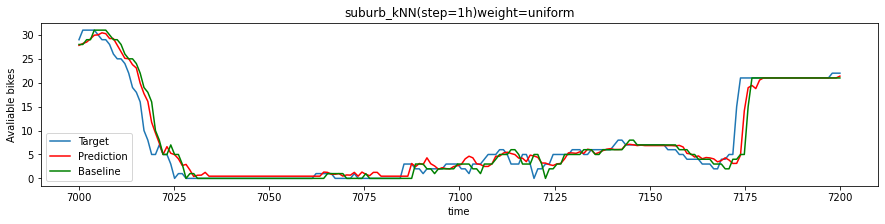

In [15]:
model = KNN(n_neighbors=50,weights='uniform')
sampletimes,target=series_to_supervised_time(cityCentre,5, start,1)
sampledays=series_to_supervised_day(cityCentre,0,start)
sampleweeks=series_to_supervised_day(cityCentre,0,start)
sample=np.concatenate((sampletimes,sampledays,sampleweeks),axis=1)

scale=MinMaxScaler()
scale.fit(sample)
sample=scale.transform(sample)

sampleTest=sample[7000:,:];targetTest=target[7000:,:];targetTest=targetTest.reshape(2792,)
sample=sample[:7000];target=target[:7000].reshape(len(target[:7000]),)

model.fit(sample,target)
pred=model.predict(sampleTest)
X=np.linspace(7000,7200,num=200).reshape(-1,1)
plt.figure(figsize=(15, 3))
#print(Min_TEMP_pred.shape)
plt.title('suburb_kNN(step=1h)weight=uniform')
plt.plot(X,targetTest[:200])
plt.plot(X,pred[:200],color='red')
plt.plot(X,baseline[7000:7200,1],color='green')
plt.xlabel('time')
plt.ylabel('Avaliable bikes')
plt.legend(['Target','Prediction','Baseline'])
print("suburb_Prediction_MSE(1h):%.4f"%mean_squared_error(pred,targetTest))
print("suburb_Prediction_MAE(1h):%.4f"%mean_absolute_error(pred,targetTest))
print("suburb_Prediction_score(1h):%.4f"%model.score(sampleTest,targetTest))